In [3]:
import sys
sys.path.append("..")
from tinylang import PCFG, train, init_model, QueryType
import pickle as pkl

from transformers import GPT2Config, GPT2LMHeadModel
import torch

from sklearn.decomposition import PCA
import pandas as pd
import plotnine as p9
from sklearn.feature_selection import r_regression

import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
pcfg = PCFG(num_terminals=20,
            num_nonterminals=10,
            max_rhs_len=10,
            max_rules_per_nt=5,
            max_depth=10,
            head_position="left",
            mask_nonquery=False)

In [5]:
pcfg.rules

defaultdict(list,
            {'nt0': [array(['t13', 't16', 't1', 't7', 't19', 't8'], dtype='<U3'),
              array(['t11', 't7', 't14', 'nt8', 'nt3', 'nt4', 'nt5', 'nt6', 't5'],
                    dtype='<U3')],
             'nt1': [array(['t6', 't8', 't2', 't0', 't12', 't1', 'nt6'], dtype='<U3'),
              array(['nt8'], dtype='<U3')],
             'nt2': [array(['t5', 't9', 't4', 't2', 'nt6', 't18', 't12', 't10', 't17'],
                    dtype='<U3'),
              array(['t9', 't14', 't15', 't17', 't0', 't19'], dtype='<U3')],
             'nt3': [array(['t15', 't2', 't11', 't16', 't19'], dtype='<U3')],
             'nt4': [array(['t12', 't14', 'nt6', 't0', 't2', 'nt3', 't15', 't5'], dtype='<U3'),
              array(['nt2', 'nt3', 't11', 'nt7', 't12', 't6', 't9', 't14'], dtype='<U3'),
              array(['t5', 't7'], dtype='<U3'),
              array(['t8'], dtype='<U3')],
             'nt5': [array(['t18', 't7'], dtype='<U3'),
              array(['nt8', 't8', 't10', 

models learn parent relation later than child / sibling - why?
* save checkpoints based on parent acc moving average

In [262]:
# defaults
n_layer = 2
n_embd = 128
n_head = 2
n_inner = 4

config = GPT2Config(
    vocab_size=pcfg.vocab_size,
    n_positions=1024,
    n_embd=n_embd,
    n_layer=n_layer,
    n_head=n_head,
    n_inner=int(n_inner * n_embd),
    activation_function="gelu_new",
    resid_pdrop=0.0,
    embd_pdrop=0.0,
    attn_pdrop=0.0,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    summary_type="cls_index",
)

early_model = GPT2LMHeadModel(config).to(device)
early_losses = train(early_model, pcfg, num_steps=500)
early_model.eval()

late_model = GPT2LMHeadModel(config).to(device)
late_losses = train(late_model, pcfg, num_steps=1000)
late_model.eval()

combined_cols = []

for i in range(len(late_losses["train_loss"])):
    add = {metric: late_losses[metric][i] for metric in late_losses}
    add["index"] = i
    combined_cols.append(add)

df = pd.DataFrame(combined_cols)
df = df.melt(id_vars=["index"])
df = df[~((df['variable'] == 'train_loss') + (df['variable'] == 'eval_loss'))]
df

Parameters: 0.531072M


Training: 100%|█| 500/500 [00:16<00:00, 29.71it/s, eval_loss=1.37, eval_prob=0.137, eval_prob_CHILD=0.165, eval_prob_PAR


Parameters: 0.531072M


Training: 100%|█| 1000/1000 [00:34<00:00, 28.60it/s, eval_loss=1.15, eval_prob=0.334, eval_prob_CHILD=0.268, eval_prob_P


,index,variable,value
2000,0,eval_prob,0.039008
2001,1,eval_prob,0.039779
2002,2,eval_prob,0.040507
2003,3,eval_prob,0.041178
2004,4,eval_prob,0.041677
...,...,...,...
5995,995,eval_prob_CHILD,0.258660
5996,996,eval_prob_CHILD,0.260863
5997,997,eval_prob_CHILD,0.264217
5998,998,eval_prob_CHILD,0.267740


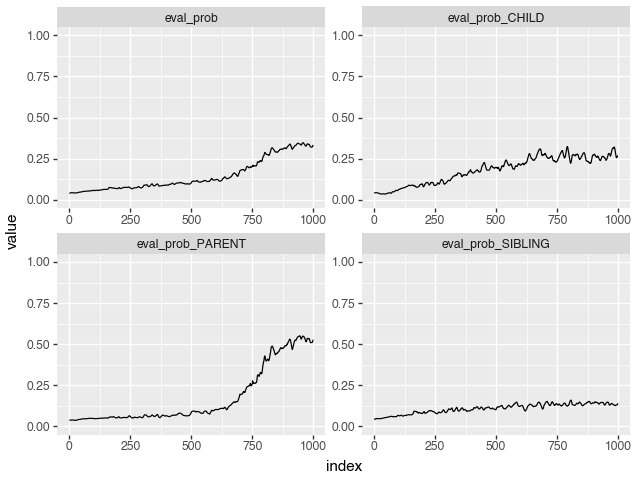

In [263]:
%config InlineBackend.figure_format = 'png'

plot = (
    # p9.ggplot(df, p9.aes(x="index", y="value", color="d", group="d")) +
    p9.ggplot(df, p9.aes(x="index", y="value", group="d")) +
    p9.geom_line() +
    p9.ylim(0, 1) +
    p9.facet_wrap("variable", scales="free") +
    p9.labs(fill="hidden dim") # +
    # p9.scale_x_log10()
)
plot.show()

# analysis 1: heuristics?

comparing
1. ...X x1 x2... | x2 parent X
2. ...X x1 x2... | x2 parent x1

19

In [270]:
num_pairs = 1000
all_pairs = []
while len(all_pairs) < 2 * num_pairs:
    
    sentence = pcfg._sample()
    query_item = np.random.randint(0, len(sentence))
    
    parents = [i for i in range(len(sentence)) if sentence[i].id == sentence[query_item].head_id]
    siblings = [i for i in range(len(sentence)) if sentence[i].head_id == sentence[query_item].head_id and sentence[i].id != sentence[query_item].id]
    
    if query_item - 1 in siblings and len(parents) == 1 and query_item - 2 == parents[0]:
        
        par_item   = int(sentence[query_item - 2].label[1:]) + pcfg.TERMINAL_START
        sib_item   = int(sentence[query_item - 1].label[1:]) + pcfg.TERMINAL_START
        query_item = int(sentence[query_item].label[1:]) + pcfg.TERMINAL_START
        
        query  = [query_item, QueryType.PARENT + pcfg.QUERY_START, par_item]
        tokens = [pcfg.BOS] + [int(x.label[1:]) + pcfg.TERMINAL_START for x in sentence] + [pcfg.EOS] + query + [pcfg.EOS]

        counter_query  = [query_item, QueryType.PARENT + pcfg.QUERY_START, sib_item]
        counter_tokens = [pcfg.BOS] + [int(x.label[1:]) + pcfg.TERMINAL_START for x in sentence] + [pcfg.EOS] + counter_query + [pcfg.EOS]
        
        all_pairs.extend([tokens, counter_tokens])

In [265]:
max_len = max(len(t) for t in all_pairs)
pairs_padded = np.stack([t + [pcfg.PAD] * (max_len - len(t)) for t in all_pairs], axis=0)
labels = pairs_padded.copy()
labels[labels == pcfg.PAD] = -100

input_ids = torch.tensor(pairs_padded, device=model.device, dtype=torch.long)
labels    = torch.tensor(labels, device=model.device, dtype=torch.long)

In [266]:
query_probs = []

with torch.no_grad():
    output = early_model(input_ids = input_ids, labels = labels)
    probs  = torch.softmax(output.logits, dim=-1) # batch_size x seq_len x vocab_size
    
    unpadded_len = (input_ids != pcfg.PAD).sum(dim=1)
    query_token = unpadded_len - 3
    query_answers = input_ids[torch.arange(len(input_ids)), query_token + 1]
    query_type = input_ids[torch.arange(len(input_ids)), query_token]
    query_probs.append(probs[torch.arange(len(probs)), query_token, query_answers])

with torch.no_grad():
    output = late_model(input_ids = input_ids, labels = labels)
    probs  = torch.softmax(output.logits, dim=-1) # batch_size x seq_len x vocab_size
    
    unpadded_len = (input_ids != pcfg.PAD).sum(dim=1)
    query_token = unpadded_len - 3
    query_answers = input_ids[torch.arange(len(input_ids)), query_token + 1]
    query_type = input_ids[torch.arange(len(input_ids)), query_token]
    query_probs.append(probs[torch.arange(len(probs)), query_token, query_answers])

df = pd.DataFrame({
    "model": ["early"] * 2 + ["late"] * 2,
    "token": ["true_parent", "prev_token"] * 2,
    "mean": [query_probs[0][::2].numpy().mean(), query_probs[0][1::2].numpy().mean(),
             query_probs[1][::2].numpy().mean(), query_probs[1][1::2].numpy().mean()]
})

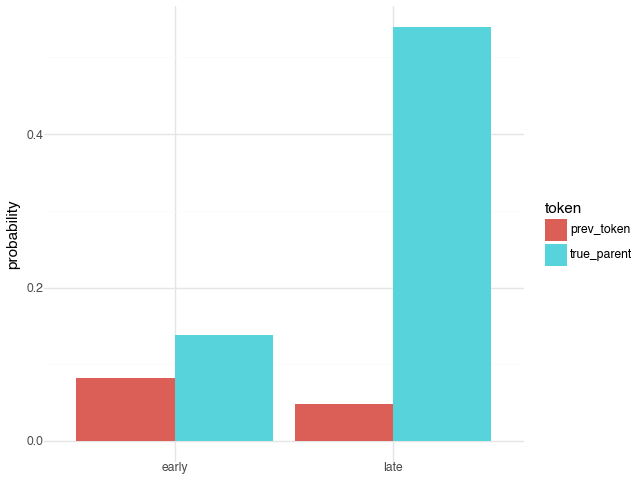

In [267]:
%config InlineBackend.figure_format = 'png'

plot = (
    p9.ggplot(df, p9.aes(x="model", y="mean", fill="token")) +
    p9.geom_bar(stat="identity", position="dodge") +
    p9.theme_minimal() +
    p9.labs(x="", y="probability")
)

plot.show()

# analysis 2: linear das?

two types of clean/corrupt pairs:

(1) corruption on query token

1. ... | x R...
2. ... | y R...

(2) corruption on relation

1. ... | x R1...
2. ... | x R2...

In [ ]:
num_pairs = 1000

all_pairs = {
    'query' : [],
    'relation' : []
}

while len(all_pairs) < 2 * num_pairs:
    
    sentence = pcfg._sample()
    query_item = np.random.randint(0, len(sentence))
    
    parents = [i for i in range(len(sentence)) if sentence[i].id == sentence[query_item].head_id]
    children = [i for i in range(len(sentence)) if sentence[i].head_id == sentence[query_item].id]
    siblings = [i for i in range(len(sentence)) if sentence[i].head_id == sentence[query_item].head_id and sentence[i].id != sentence[query_item].id]

    query_item = int(sentence[query_item].label[1:]) + self.TERMINAL_START

    acceptable_query_types = []
    
    if len(parents) > 0:
        acceptable_query_types.append(QueryType.PARENT)
    if len(children) > 0:
        acceptable_query_types.append(QueryType.CHILD)
    if len(siblings) > 0:
        acceptable_query_types.append(QueryType.SIBLING)
    
    if len(acceptable_query_types) < 2:
        continue
    
    query_type = np.random.choice(acceptable_query_types)
    
    acceptable_query_types.remove(query_type)
    corrupt_query_type = np.random.choice(acceptable_query_types)
    
    if query_type == QueryType.PARENT:
        target_item = np.random.choice(parents)
    elif query_type == QueryType.CHILD:
        target_item = np.random.choice(children)
    elif query_type == QueryType.SIBLING:
        target_item = np.random.choice(siblings)
    
    target_item = int(sentence[target_item].label[1:]) + self.TERMINAL_START
    
    clean_query = [query_item, query_type + self.QUERY_START, target_item]
    clean_tokens = [self.BOS] + [int(x.label[1:]) + self.TERMINAL_START for x in sentence] + [self.EOS] + query + [self.EOS]

    corrupt_query = [query_item, corrupt_query_type + self.QUERY_START, target_item]
    corrupt_tokens = [self.BOS] + [int(x.label[1:]) + self.TERMINAL_START for x in sentence] + [self.EOS] + query + [self.EOS]

